In [1]:
%reset -f

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import data_process, data_functions, data_generator, keras_model
from path import path_dict, col_seq_cc, col_seq_can

In [6]:
%config Completer.use_jedi = False

In [7]:
#### load pmpm data only
_, _, pmpm = data_process.load_data(path_dict)

In [8]:
pmpm.MYR.min(), pmpm.MYR.max()

(201701, 202107)

In [9]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [10]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [11]:
def get_training_date_range(pmpm, start, end):
    date_list = pmpm.MYR.sort_values().unique().tolist()
    start_index = date_list.index(start)
    end_index = date_list.index(end)
    return date_list[start_index:end_index+1]

In [21]:
def return_stacked_training_data(pmpm, train_start, train_end, offset):
    
    training_period = get_training_date_range(pmpm.copy(), train_start, train_end)
    print(f"Training Period {training_period}")
    
    feature_start = [i for (i, _) in enumerate(training_period) if i%offset==0]
    feature_end   = [i+(offset-1) for i in feature_start]
    label_start   = [feature_start[i] for (i,_) in enumerate(feature_start) if i>0]
    label_end     = [feature_end[i] for (i,_) in enumerate(feature_end) if i>0]

    feature_start = feature_start[:-1]
    feature_end   = feature_end  [:-1]

    print(f"Feature Start Month Indices: {feature_start}")
    print(f"Feature End Month Indices: {feature_end}")
    print(f"Label Start Month Indices: {label_start}")
    print(f"Label End Month Indices: {label_end}")
    
    for i, val in enumerate(feature_start):
        if i==0:
            training_features, sample_weight = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_can)
            training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_can)
            training_features, training_labels = data_generator.make_intersection(training_features, training_labels)
            training_features, sample_weight = data_generator.make_intersection(training_features, sample_weight)
            
            training_features = training_features.set_index('PERS_ID')
            training_labels = training_labels.set_index('PERS_ID')
            
            print(f"{training_features.shape} samples added with {training_labels.shape} labels and {sample_weight.shape} weights")

        else:
            new_training_features, new_sample_weights = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_can)
            new_training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_can)
            
            new_training_features, new_training_labels = data_generator.make_intersection(new_training_features, new_training_labels)
            new_training_features, new_sample_weights = data_generator.make_intersection(new_training_features, new_sample_weights)
            
            new_training_features = new_training_features.set_index('PERS_ID')
            new_training_labels = new_training_labels.set_index('PERS_ID')

            print(f"{new_training_features.shape} samples added with {new_training_labels.shape} labels and {new_sample_weights.shape} weights")
            

            training_features = training_features.append(new_training_features, ignore_index=True)
            training_labels   = training_labels.append(new_training_labels, ignore_index=True)
            sample_weight     = sample_weight.append(new_sample_weights, ignore_index=True)

        print(f"Current Trainset size {training_features.shape}")
        
    return training_features, training_labels, sample_weight

In [22]:
%%time
train_data, training_labels, sample_weight = return_stacked_training_data(pmpm.copy(), 201701, 202012, offset=12)

Training Period [201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012]
Feature Start Month Indices: [0, 12, 24]
Feature End Month Indices: [11, 23, 35]
Label Start Month Indices: [12, 24, 36]
Label End Month Indices: [23, 35, 47]


PERS_ID  AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  \
1  2562798       102.666667  1.0       0.0   3.485676 -12.503763 -16.118096   
3  2563500       101.000000  1.0       0.0   0.340103 -16.118096 -16.118096   
4  2563709       100.500000  1.0       0.0 -10.957575 -16.118096 -16.118096   

   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  ...  CC_PROSTATE_CANCER  CC_PTSD  \
1      0.0           0.0           0.000000  ...                 0.0      0.0   
3      0.0           0.0           1.000000  ...                 0.0      0.0   
4      0.0           0.0           0.583333  ...                 0.0      0.0   

   CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  \
1               0.0                     0.0             0.0              0.0   
3               0.0                     0.0             0.0              0.0   
4               0.0                     0.0             0.0              0.0   

   CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
1        0.0         0.0                 0.0          0.000000  
3        0.0         0.0                 0.0          0.083333  
4        0.0         0.0                 0.0          0.000000  

[3 rows x 76 columns]

(109097, 75) samples added with (109097, 75) labels and (109097, 3) weights
Current Trainset size (109097, 75)
(116104, 75) samples added with (116104, 75) labels and (116104, 3) weights


AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  \
PERS_ID                                                                    
2561296        38.833333  1.0       1.0 -12.587981 -16.118096 -16.118096   
2562798       103.727273  1.0       0.0   4.932828 -16.118096 -16.118096   
2563500       102.000000  1.0       0.0   3.970094 -16.118096 -16.118096   

         CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  ...  \
PERS_ID                                                    ...   
2561296      0.0           0.0                0.0     0.0  ...   
2562798      0.0           0.0                0.0     0.0  ...   
2563500      0.0           0.0                1.0     0.0  ...   

         CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  \
PERS_ID                                                  
2561296                 0.0      0.0               0.0   
2562798                 0.0      0.0               0.0   
2563500                 0.0      0.0               0.0   

         CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  \
PERS_ID                                                                       
2561296                     0.0             0.0              0.0        0.0   
2562798                     0.0             0.0              0.0        0.0   
2563500                     0.0             0.0              0.0        0.0   

         CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
PERS_ID                                                    
2561296         0.0                 0.0               0.0  
2562798         0.0                 0.0               0.0  
2563500         0.0                 0.0               0.0  

[3 rows x 75 columns]

Current Trainset size (225201, 75)
(127419, 75) samples added with (127419, 75) labels and (127419, 3) weights


AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  \
PERS_ID                                                                    
2561296        39.416667  1.0       1.0 -10.802429 -16.118096 -16.118096   
2562798       104.666667  1.0       0.0   5.631576  -8.597024 -16.118096   
2563861       102.250000  1.0       0.0   5.614447 -14.331422 -16.118096   

         CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  ...  \
PERS_ID                                                    ...   
2561296      0.0           0.0           0.000000     0.0  ...   
2562798      0.0           0.0           0.083333     0.0  ...   
2563861      0.0           0.0           0.000000     0.0  ...   

         CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  \
PERS_ID                                                  
2561296                 0.0      0.0               0.0   
2562798                 0.0      0.0               0.0   
2563861                 0.0      0.0               0.0   

         CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  \
PERS_ID                                                                       
2561296                     0.0             0.0              0.0        0.0   
2562798                     0.0             0.0              0.0        0.0   
2563861                     0.0             0.0              0.0        0.0   

         CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
PERS_ID                                                    
2561296         0.0                 0.0               0.0  
2562798         0.0                 0.0               0.0  
2563861         0.0                 0.0               0.0  

[3 rows x 75 columns]

Current Trainset size (352620, 75)
CPU times: user 1min 19s, sys: 24.2 s, total: 1min 43s
Wall time: 1min 43s


In [24]:
milestone_markers = [109097, 116104, 127419]

In [29]:
train_data = train_data.dropna()

In [33]:
train_data.head()

AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  CC_ADHD  \
0       102.666667  1.0       0.0   3.485676 -12.503763 -16.118096      0.0   
1       101.000000  1.0       0.0   0.340103 -16.118096 -16.118096      0.0   
2       100.500000  1.0       0.0 -10.957575 -16.118096 -16.118096      0.0   
3       100.166667  1.0       0.0   5.924166 -16.118096 -16.118096      0.0   
4        99.833333  1.0       0.0   3.734474 -16.118096 -16.118096      0.0   

   CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  ...  CC_PROSTATE_CANCER  CC_PTSD  \
0           0.0           0.000000     0.0  ...                 0.0      0.0   
1           0.0           1.000000     0.0  ...                 0.0      0.0   
2           0.0           0.583333     0.0  ...                 0.0      0.0   
3           1.0           1.000000     0.0  ...                 0.0      0.0   
4           0.0           0.000000     0.0  ...                 0.0      0.0   

   CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  \
0               0.0                     0.0             0.0              0.0   
1               0.0                     0.0             0.0              0.0   
2               0.0                     0.0             0.0              0.0   
3               0.0                     0.0             0.0              0.0   
4               0.0                     0.0             0.0              0.0   

   CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0        0.0         0.0                 0.0          0.000000  
1        0.0         0.0                 0.0          0.083333  
2        0.0         0.0                 0.0          0.000000  
3        0.0         0.0                 0.0          1.000000  
4        0.0         0.0                 0.0          0.000000  

[5 rows x 75 columns]

In [31]:
training_labels = training_labels.dropna()

In [34]:
training_labels.head()

AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  CC_ADHD  \
0       103.727273  1.0       0.0   4.932828 -16.118096 -16.118096      0.0   
1       102.000000  1.0       0.0   3.970094 -16.118096 -16.118096      0.0   
2       101.500000  1.0       0.0  -1.326767 -14.207248 -16.118096      0.0   
3       101.166667  1.0       0.0   5.634987 -16.118096 -16.118096      0.0   
4       100.818182  1.0       0.0   6.108862 -14.218303 -13.795429      0.0   

   CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  ...  CC_PROSTATE_CANCER  CC_PTSD  \
0           0.0                0.0     0.0  ...                 0.0      0.0   
1           0.0                1.0     0.0  ...                 0.0      0.0   
2           0.0                1.0     0.0  ...                 0.0      0.0   
3           1.0                1.0     0.0  ...                 0.0      0.0   
4           0.0                0.0     0.0  ...                 0.0      0.0   

   CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  \
0               0.0                     0.0             0.0              0.0   
1               0.0                     0.0             0.0              0.0   
2               0.0                     0.0             0.0              0.0   
3               0.0                     0.0             0.0              0.0   
4               0.0                     0.0             0.0              0.0   

   CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0        0.0    0.000000                 0.0               0.0  
1        0.0    0.000000                 0.0               0.0  
2        0.0    0.000000                 0.0               0.0  
3        0.0    0.000000                 0.0               1.0  
4        0.0    0.181818                 0.0               0.0  

[5 rows x 75 columns]

# Test Data

In [35]:
# test_features, test_sample_weights = data_generator.generate_data(pmpm.copy(), 202001, 
#                                                              202012, features=True, 
#                                                              col_seq=col_seq_can)

In [36]:
# test_features

In [37]:
# test_labels, _ = data_generator.generate_data(pmpm.copy(), 202101, 
#                                                              202107, features=False, 
#                                                              col_seq=col_seq_can)

In [38]:
# test_labels.shape

In [39]:
# test_features, test_labels = data_generator.make_intersection(test_features, test_labels)

## Sample weight calculation

In [40]:
sample_weight

PERS_ID   0    weight
0       2562798  12  1.000000
1       2563500  12  1.000000
2       2563709  12  1.000000
3       2563892  12  1.000000
4       2564074  12  1.000000
...         ...  ..       ...
352615  5011414   6  0.500000
352616  5012290   6  0.500000
352617  5014353  10  0.833333
352618  5030276   7  0.583333
352619  5052049  12  1.000000

[352620 rows x 3 columns]

In [41]:
sample_weight.weight.values

array([1.        , 1.        , 1.        , ..., 0.83333333, 0.58333333,
       1.        ])

## Training

In [42]:
baseline_model = keras_model.make_model_6(input_shape=train_data.shape[1])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [43]:
%%time
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_data.values, training_labels.values, epochs=num_epochs, validation_split=0.1, 
                                      batch_size=128, verbose=1, sample_weight=sample_weight.weight.values)

Train on 317358 samples, validate on 35262 samples
Epoch 1/20
317358/317358 [==============================] - 7s 22us/step - loss: 8.4302 - val_loss: 1.7638
Epoch 2/20
317358/317358 [==============================] - 6s 20us/step - loss: 3.2420 - val_loss: 1.8470
Epoch 3/20
317358/317358 [==============================] - 6s 20us/step - loss: 3.0181 - val_loss: 1.6532
Epoch 4/20
317358/317358 [==============================] - 6s 20us/step - loss: 2.8703 - val_loss: 1.4209
Epoch 5/20
317358/317358 [==============================] - 6s 20us/step - loss: 2.7407 - val_loss: 1.6744
Epoch 6/20
317358/317358 [==============================] - 6s 20us/step - loss: 2.6341 - val_loss: 1.5118
Epoch 7/20
317358/317358 [==============================] - 6s 20us/step - loss: 2.5659 - val_loss: 1.3640
Epoch 8/20
317358/317358 [==============================] - 6s 20us/step - loss: 2.4944 - val_loss: 1.5443
Epoch 9/20
317358/317358 [==============================] - 7s 20us/step - loss: 2.4414 - val

In [44]:
baseline_history.history.keys()

dict_keys(['val_loss', 'loss'])

In [49]:
pd.DataFrame(baseline_history.history).to_csv("Error_epoch_MHTM.csv", header=True, index=False)

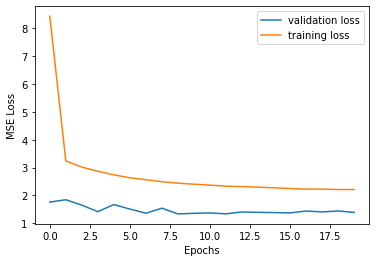

In [51]:
import matplotlib.pyplot as plt
plt.plot(baseline_history.history.get('val_loss'), label="validation loss")
plt.plot(baseline_history.history.get('loss'), label="training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('MSE Loss')
plt.savefig("Loss MHTM.jpg")
plt.show()

# Prediction Performance on 2019-2020 Data

In [73]:
train_slice_2019_features = train_data.loc[milestone_markers[0]+milestone_markers[1]:,:]
train_slice_2019_labels   = training_labels.loc[milestone_markers[0]+milestone_markers[1]:,:]
predicted_labels_2019     = pd.DataFrame(baseline_model.predict(train_slice_2019_features.values), columns=train_slice_2019_labels.columns)

In [105]:
baseline_model.evaluate(train_slice_2019_features.values,train_slice_2019_labels.values, batch_size=128)

127419/127419 [==============================] - 1s 5us/step


1.2884052982717198

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [75]:
mean_absolute_error(train_slice_2019_labels, predicted_labels_2019)

0.23879562153733497

In [76]:
mean_squared_error(train_slice_2019_labels, predicted_labels_2019, squared=True)

0.9842869818544764

In [77]:
#RMSE
mean_squared_error(train_slice_2019_labels, predicted_labels_2019, squared=False)

0.36249731015844283

In [81]:
predA = predicted_labels_2019.describe().loc[['mean', 'std', 'count']].T
predA['count'] = predA['count'].astype(int)

In [82]:
trueA = train_slice_2019_labels.describe().loc[['mean', 'std', 'count']].T
trueA['count'] = trueA['count'].astype(int)

In [91]:
baseA = train_slice_2019_features.describe().loc[['mean', 'std', 'count']].T
baseA['count'] = baseA['count'].astype(int)

In [101]:
pd.concat((baseA, trueA, predA), axis=1, keys=['Baseline 2019', 'Actual 2020', 'Predicted 2020']).round(4).to_csv("MHTM_prediction_stats_2019_2020.csv", index=True, header=True)

# Save

In [46]:
# latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [47]:
# #freeze all the layers in both models
# for layer in baseline_model.layers:
#     layer.trainable=False
# for layer in latent_model.layers:
#     layer.trainable=False

In [48]:
# ## save the models
# baseline_model.save('../temp/TF_Full_Model_m6_Canary_stacked_AE_logfixed')
# latent_model.save('../temp/TF_Latent_Model_m6_Canary_stacked_AE_logfixed')

In [50]:
# #save in S3
# import boto3
# s3 = boto3.client('s3')
# bucket = 'cdphp-s3-us-e-p-pond'
# s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m6_Canary_stacked_AE_logfixed',
#                 bucket, 
#                 'rpi/nneehal/MODELS/TF_Latent_Model_m6_Canary_stacked_AE_logfixed',
#                 ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
# s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m6_Canary_stacked_AE_logfixed',
#                 bucket, 
#                 'rpi/nneehal/MODELS/TF_Full_Model_m6_Canary_stacked_AE_logfixed',
#                 ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})